# getting average response within ROI across multiple traces: step-by-step


In [1]:
import lib.fileIngest as fileIngest

xsgs = []
# dPaths = ["/media/DATA/MAK/GRISZ_02/AA0001","/media/DATA/MAK/GRISZ_03/AA0001","/media/DATA/MAK/GRISZ_05/AA0001"]
dPaths = ["/Users/pacody/Documents/code/python/pyFluo/data/AA0308"]
# dPaths = ["/home/pac/Documents/Python/pyFluo/data/AA0310"]
# dPaths = ["/home/pac/Documents/Python/pyFluo/data/AA0315"]

df = fileIngest.qcamPath2table(dPaths,format='PAC')
df

,qcam,dir,xsg,pulse,dB
0,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
1,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5612Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
2,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5000Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
3,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,12599Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
4,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
5,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5453Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
6,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5297Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
7,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5000Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
8,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5453Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
9,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70


In [2]:
# 1. get list of qcams
# 2. get average image 
# 3. calc spatial dff response
# 4. get mask 
# 5. apply mask over each file

In [3]:
dB = 60

# 1.
qcams = df[df['dB']==dB]['qcam'].tolist()
qcams

['/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0003.qcamraw',
 '/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0008.qcamraw',
 '/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0010.qcamraw',
 '/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0009.qcamraw',
 '/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0005.qcamraw',
 '/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0004.qcamraw']

In [4]:
import numpy as np

# 2.
imgs,headers = fileIngest.qcams2imgs(qcams)
print(imgs[0].shape)
print(len(imgs))
avgImgSeries = np.array(imgs).mean(axis=(0))
np.array(avgImgSeries).shape

(150, 200, 200)
6


(150, 200, 200)

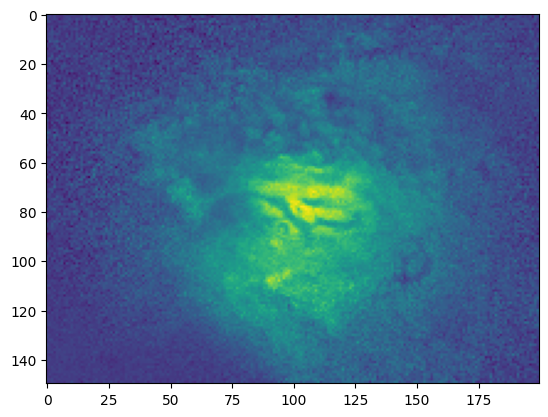

In [5]:
import lib.imgProcess as imgProcess
import matplotlib.pyplot as plt

# 3.
t = fileIngest.getTimeVec(imgs[0].shape[2])
spatialDFF = imgProcess.calcSpatialDFFresp(avgImgSeries,t)
plt.imshow(spatialDFF)

BokehModel(combine_events=True, render_bundle={'docs_json': {'eedbe554-bcff-43f8-89b1-428d73b51b36': {'version…

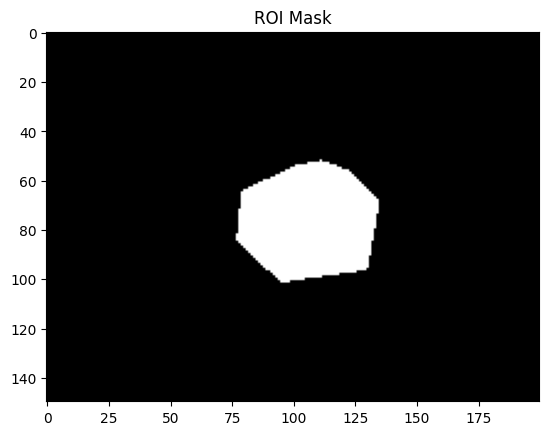

In [6]:
# 4. get mask
ui, mask_output = imgProcess.getROImaskUI(spatialDFF)
# Show the UI
ui

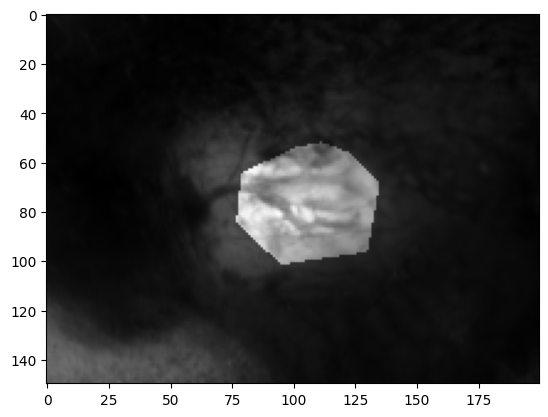

In [7]:
plt.imshow(avgImgSeries.mean(axis=2)*(mask_output['mask']+.5),cmap='gray')

In [8]:
np.array(imgs)[:,mask_output['mask']==1,:].shape

(6, 2180, 200)

Text(0.5, 1.0, 'roi')

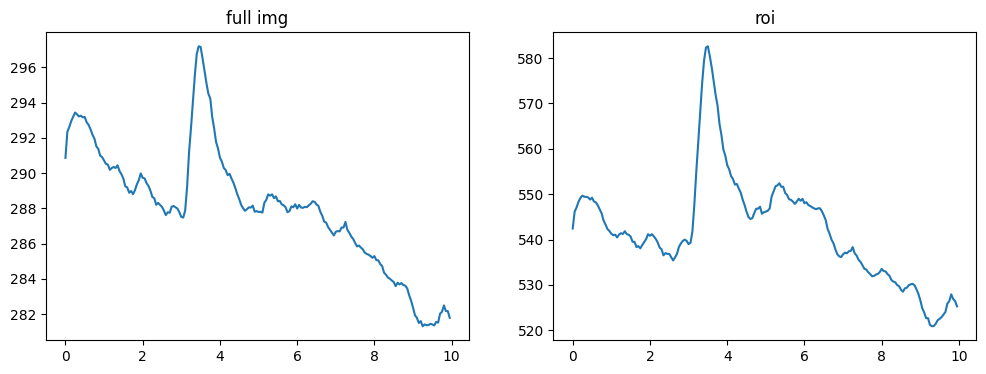

In [9]:
# 5. apply mask

# if want mask for each trace:
# np.array(imgs)[:,mask_output['mask']==1,:]

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(t,avgImgSeries.mean(axis=(0,1)))
ax[0].set_title('full img')
ax[1].plot(t,avgImgSeries[mask_output['mask']==1,:].mean(axis=0))
ax[1].set_title('roi')


Text(0.5, 1.0, 'roi')

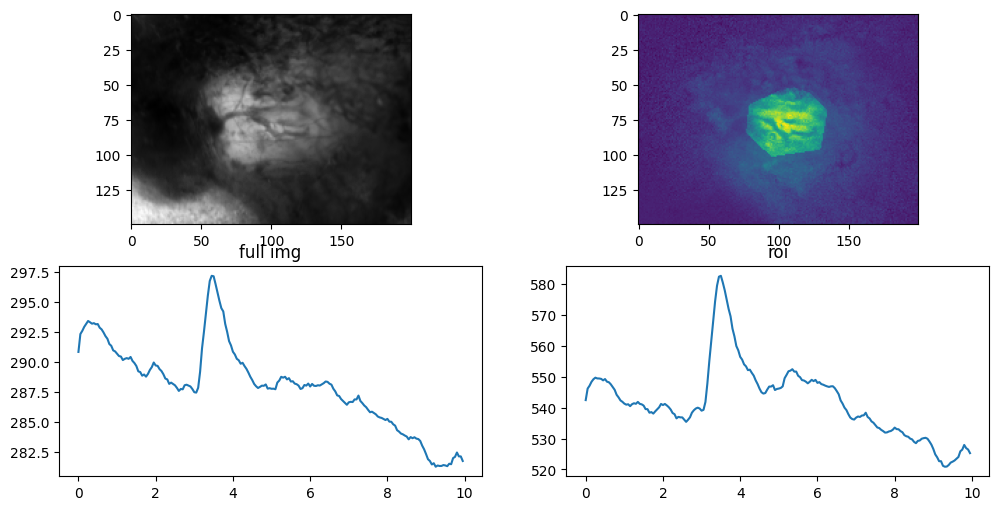

In [10]:
fig,ax = plt.subplots(2,2,figsize=(12,6))
ax[0,0].imshow(avgImgSeries.mean(axis=2),cmap='gray')
ax[0,1].imshow(spatialDFF*(mask_output['mask']+.8),cmap='viridis')
ax[1,0].plot(t,avgImgSeries.mean(axis=(0,1)))
ax[1,0].set_title('full img')
ax[1,1].plot(t,avgImgSeries[mask_output['mask']==1,:].mean(axis=0))
ax[1,1].set_title('roi')

# as function

In [4]:
import lib.fileIngest as fileIngest
import lib.imgProcess as imgProcess

xsgs = []
# dPaths = ["/media/DATA/MAK/GRISZ_02/AA0001","/media/DATA/MAK/GRISZ_03/AA0001","/media/DATA/MAK/GRISZ_05/AA0001"]
dPaths = ["/Users/pacody/Documents/code/python/pyFluo/data/AA0308"]
# dPaths = ["/home/pac/Documents/Python/pyFluo/data/AA0310"]
# dPaths = ["/home/pac/Documents/Python/pyFluo/data/AA0315"]

df = fileIngest.qcamPath2table(dPaths,format='PAC')
df

,qcam,dir,xsg,pulse,dB
0,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
1,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5612Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
2,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5000Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
3,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,12599Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
4,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
5,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5453Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
6,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5297Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
7,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5000Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
8,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,5453Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
9,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,/Users/pacody/Documents/code/python/pyFluo/dat...,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70


In [5]:
dB = 70

# 1.
qcams = df[df['dB']==dB]['qcam'].tolist()
qcams

['/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0002.qcamraw',
 '/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0011.qcamraw',
 '/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0001.qcamraw',
 '/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0006.qcamraw',
 '/Users/pacody/Documents/code/python/pyFluo/data/AA0308/AA0308AAAA0007.qcamraw']

In [6]:
ui,dmask,imgs,spatialDFF,t = imgProcess.qcams2roiTrace(qcams)
ui

BokehModel(combine_events=True, render_bundle={'docs_json': {'6a963979-aa25-475a-bd72-6b430aeac196': {'version…

/Users/pacody/Documents/code/python/pyFluo/src/lib/imgProcess.py:252: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(5, 200)

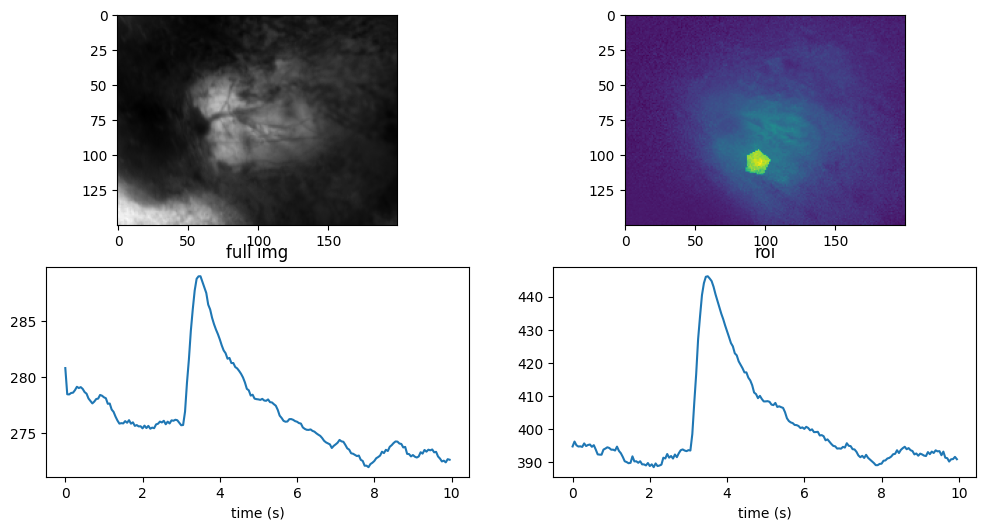

In [7]:
roiTrace = imgProcess.mask2trace(dmask['mask'], imgs, spatialDFF, t)
roiTrace.shape